## Load Libraries

In [ ]:
import re
import string
import warnings
warnings.filterwarnings("ignore")

import nltk
import numpy as np
import pandas as pd
from nltk.corpus import stopwords

import seaborn as sns
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import lightgbm as lgb
from keras.models import Model
import gensim.downloader as api
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Bidirectional
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers, Sequential

from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, train_test_split, learning_curve
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer

In [ ]:
# path/to/data
TRAIN_PATH = "../content/train.csv"
TEST_PATH = "../content/test.csv"


## https://github.com/kurtispykes/twitter-sentiment-analysis/blob/master/notebook/03_kpy_data_exploration.ipynb - Kaggle source for his code ##

In [ ]:
# read data
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)

print(f"Train data shape: {train_df.shape}\nTest data shape: {test_df.shape}")

Train data shape: (7613, 5)
Test data shape: (3263, 4)


In [ ]:
# more information about columns 
print(train_df.info())
print("\n-----------------------------------------\n")
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None

-----------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB
None


In [ ]:
# number of missing values per column in train 
train_df.isna().sum()


id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [ ]:
# number of missing values per column in test
test_df.isna().sum()


id             0
keyword       26
location    1105
text           0
dtype: int64

In [ ]:
# number of missing values per column in test
test_df.isna().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [ ]:
# checking if any id's from train are in test
train_df["id"].isin(test_df["id"]).value_counts()

False    7613
Name: id, dtype: int64

In [ ]:
# number of text that's duplicated in train and test sets
train_df["text"].isin(test_df["text"]).value_counts()

False    7486
True      127
Name: text, dtype: int64

In [ ]:
# appending the test data to train 
full_df = pd.concat(objs=[train_df, test_df], axis=0)
full_df.head() # train data would be above the test data

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1.0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1.0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1.0


In [ ]:
# target should be NaN if concat performed correctly
full_df.tail()

,id,keyword,location,text,target
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,NaN
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,NaN
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,NaN
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,NaN
3262,10875,NaN,NaN,#CityofCalgary has activated its Municipal Eme...,NaN


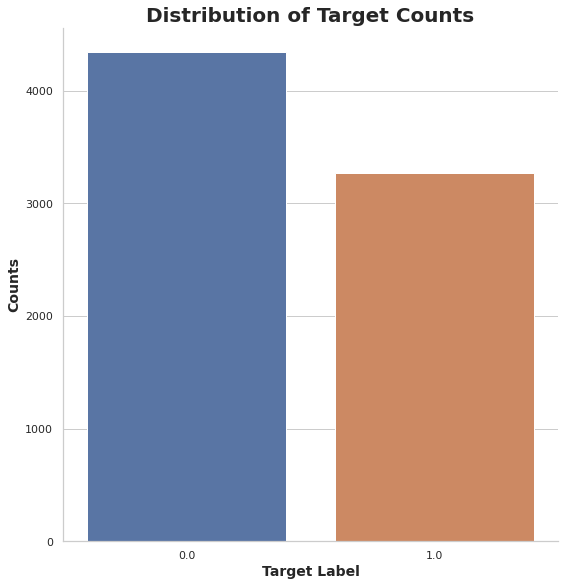

In [ ]:
# counting the number of positive and negative tweets
sns.set(style="whitegrid", color_codes=True)
sns.catplot("target", data=full_df, kind="count", height=8)
plt.title("Distribution of Target Counts", size=20, weight="bold")
plt.xlabel("Target Label", size=14, weight="bold")
plt.ylabel("Counts", size=14, weight="bold")
plt.show()

In [ ]:
# random examples of disaster tweets 
full_df[full_df["target"]==1].iloc[np.random.randint(0, 3000), -2] # will give new example after each run

'HURRICANE GUILLERMO LIVE NOAA TRACKING / LOOPING WED.AUG.5TH ~ http://t.co/RjopJKbydR ~  http://t.co/NUFDgw9YEv http://t.co/2oKSCwYoHC'

In [ ]:
# random examples of non-disaster tweets 
full_df[full_df["target"]==0].iloc[np.random.randint(0, 4000), -2] # will give new example after each run

'#nowplaying Sinking Fast - Now or Never on North East Unsigned Radio listen at http://t.co/QymAlttvZp'

### Percentage of missing values

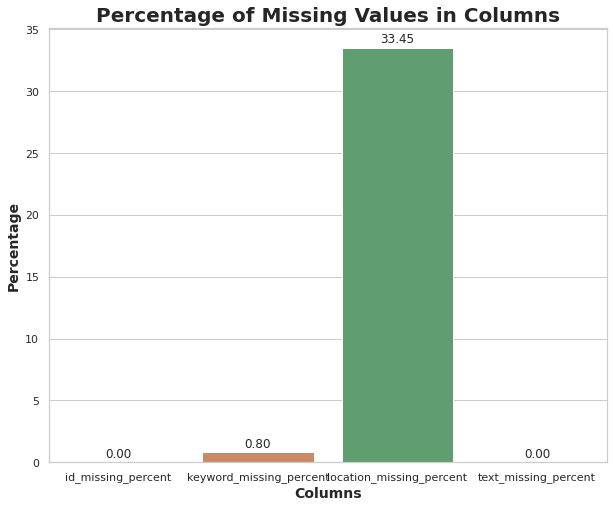

In [ ]:
# creating a new dataframe for missing values percentage
missing_values = dict(zip([col+"_missing_percent" for col in full_df.columns if col != "target"],
                          [round(100*full_df[col].isnull().sum()/len(full_df), 2) for col in full_df.columns
                           if col != "target"]))
missing_values_df = pd.DataFrame(missing_values, index=[0])
missing_values_df = missing_values_df.melt(var_name= "columns", value_name= "percentage")

# plotting missing values chart
plt.figure(figsize=(10, 8))
sns.set(style="whitegrid", color_codes=True)
seaborn_plot = sns.barplot(x="columns", y="percentage", data=missing_values_df)
for p in seaborn_plot.patches:
    seaborn_plot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center',
                   va = 'center', xytext = (0, 9), textcoords = 'offset points')
plt.title("Percentage of Missing Values in Columns", size=20, weight="bold")
plt.xlabel("Columns", size=14, weight="bold")
plt.ylabel("Percentage", size=14, weight="bold")
plt.show()

### Unique Values Per Column

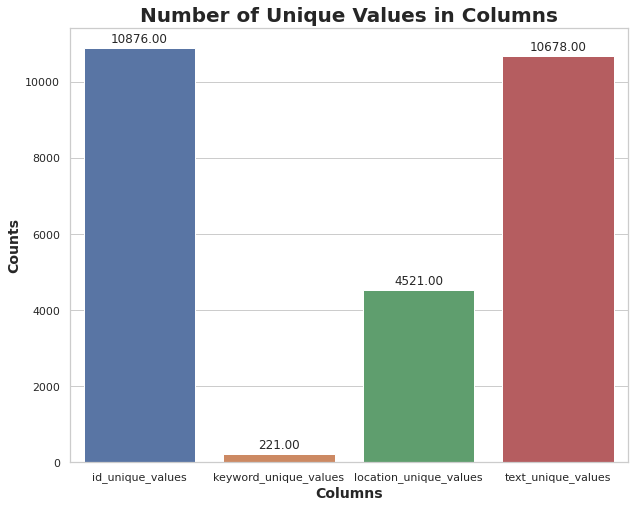

In [ ]:
# creating a new dataframe for unique value cound
unique_values = dict(zip([col+"_unique_values" for col in full_df.columns if col != "target"],
                          [full_df[col].nunique() for col in full_df.columns if col != "target"]))
unique_values_df = pd.DataFrame(unique_values, index=[0])
unique_values_df = unique_values_df.melt(var_name= "columns", value_name= "counts")

# plotting unique values chart
plt.figure(figsize=(10, 8))
sns.set(style="whitegrid", color_codes=True)
seaborn_plot = sns.barplot(x="columns", y="counts", data=unique_values_df)
for p in seaborn_plot.patches:
    seaborn_plot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center',
                   va = 'center', xytext = (0, 9), textcoords = 'offset points')
plt.title("Number of Unique Values in Columns", size=20, weight="bold")
plt.xlabel("Columns", size=14, weight="bold")
plt.ylabel("Counts", size=14, weight="bold")
plt.show()

**Note: 198 Tweets are not unique --> We have duplicates (Explore!)**

### Top Locations in Tweets

In [ ]:
# creating a new dataframe with value counts of each location
locations= full_df["location"].value_counts().sort_values(ascending=False)
locations_df= pd.DataFrame(dict(zip(locations.index, locations.values)), index=[0]).\
                                melt(var_name="location", value_name="unique_counts")
locations_df.loc[:10]

,location,unique_counts
0,USA,141
1,New York,109
2,United States,65
3,London,58
4,Canada,42
5,Nigeria,40
6,India,35
7,Worldwide,35
8,"Los Angeles, CA",34
9,UK,33


In [ ]:
# plotting in a graph 
data = {
    "values": locations_df["unique_counts"].loc[:10],
    "labels": locations_df["location"].loc[:10],
    "domain": {"column": 0},
    "hoverinfo": "label + percent",
    "type": "pie"
}
layout = go.Layout(title= "<b>Top 10 Locations from Tweets</b>",
                   legend= dict(x=0.1, y=1.1, orientation="h"))

fig = go.Figure(data=[data], layout=layout)
fig.update_layout(title_x=0.5)
fig.show()

In [ ]:
# replacing some names from locations to be all countries
replace_names= {
    "USA":"United States",
    "New York":"United States",
    "Los Angeles": "United States",
    "Los Angeles, CA":"United States",
    "Washington, DC": "United States",
    "San Francisco": "United States",
    "San Francisco, CA": "United States",
    "Chicago, IL": "United States",
    "Chicago": "United States",
    "New York, NY": "United States",
    "NYC": "United States",
    "Florida": "United States",
    "London": "UK",
    "United Kingdom": "UK",
    "Mumbai": "India",
    "California": "United States",
    "California, USA": "United States",
    "Toronto": "Canada",
    "Washington, D.C.": "United States",
    "Everywhere": "Worldwide",
    "Seattle": "United States",
    "ss": "Worldwide"
}

countries = full_df["location"].replace(replace_names).value_counts().sort_values(ascending=False)
countries_df= pd.DataFrame(dict(zip(countries.index, countries.values)), index=[0]).\
                                melt(var_name="country", value_name="unique_counts")
# Note: Counts may not be accurate because not all area's have been replaced! 
countries_df.loc[:10]

,country,unique_counts
0,United States,627
1,UK,117
2,Worldwide,64
3,India,63
4,Canada,58
5,Nigeria,40
6,Kenya,32
7,Australia,25
8,Indonesia,15
9,Ireland,15


In [ ]:
# A world plot with each of these locations highlighted with a heatmap displaying area's with higher unique counts
data = {
    "locations": countries_df.loc[:10, "country"],
    "locationmode": "country names",
    "z": countries_df.loc[:10, "unique_counts"],
    "colorscale": "Rainbow",
    "text": countries_df.loc[:10, "country"],
    "type": "choropleth",
    "colorbar": {"title": "Unique Counts", "len": 200, "lenmode":"pixels"}
}

layout = go.Layout(title_text= "<b>Tweet Locations of Top 10 Countries</b>",
                   geo= dict(scope= "world"))

fig = go.Figure(data=[data], layout=layout)
fig.update_layout(title_x=0.5)
fig.show()

### Number of Disaster tweets in each location

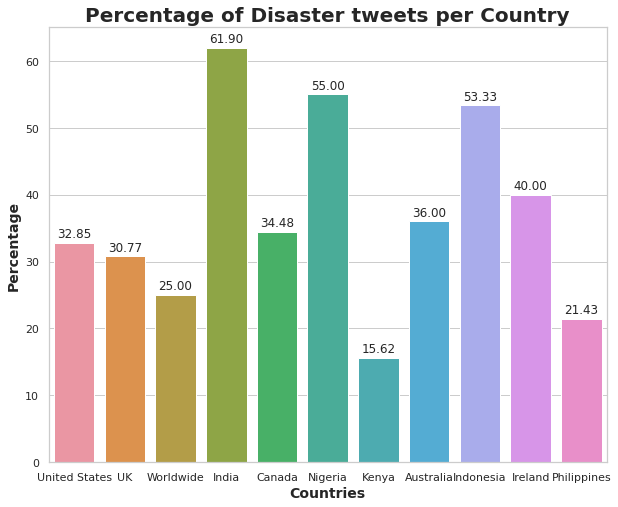

In [ ]:
# creating new dataframe to replace the names we changed
df2 = full_df.copy()
df2["location"].replace(replace_names, inplace=True)

# count the number of disaster tweets in each location
country_disaster_tweets = df2[df2["location"].isin(countries_df.loc[:10, "country"])].groupby("location")["target"].sum()
country_disaster_tweets_df = pd.merge(left=countries_df, right=country_disaster_tweets, left_on="country", right_on="location")

# renaming target column
country_disaster_tweets_df.rename(columns={"target":"disaster_tweets"}, inplace=True)
country_disaster_tweets_df["percent_disaster_tweets"] = round(100 * country_disaster_tweets_df["disaster_tweets"]\
                                                              / country_disaster_tweets_df["unique_counts"], 2)

# plotting the percentages
plt.figure(figsize=(10, 8))
sns.set(style="whitegrid", color_codes=True)
seaborn_plot = sns.barplot(x="country", y="percent_disaster_tweets", data=country_disaster_tweets_df)
for p in seaborn_plot.patches:
    seaborn_plot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center',
                   va = 'center', xytext = (0, 9), textcoords = 'offset points')
plt.title("Percentage of Disaster tweets per Country", size=20, weight="bold")
plt.xlabel("Countries", size=14, weight="bold")
plt.ylabel("Percentage", size=14, weight="bold")
plt.show()

### Duplicate Tweets

In [ ]:
# all duplicate tweets
duplicated_df = full_df[full_df["text"].duplicated()]

print(f"Number of Duplicated Tweets in Train & Test: {len(duplicated_df)}\n\
Number of Duplicated Tweets in Train: {duplicated_df['target'].notna().sum()}\n\
Number of Duplicated Tweets in Test: {duplicated_df['target'].isna().sum()}\n")

Number of Duplicated Tweets in Train & Test: 198
Number of Duplicated Tweets in Train: 110
Number of Duplicated Tweets in Test: 88



In [ ]:
# add all the tweets with duplicates
train_duplicates = train_df[train_df["text"].duplicated()].groupby(["text"])[["target"]].agg(list)

diff_label_idx = []
for idx, val in enumerate(train_duplicates["target"]):
    for ele in val: 
        if ele != val[0]:
            diff_label_idx.append(idx)
                
print(f"Number of Duplicated Tweets with different target labels in train: {len(diff_label_idx)}")

Number of Duplicated Tweets with different target labels in train: 12


In [ ]:
# tweets with different labels
train_duplicates.iloc[diff_label_idx]

,target
text,
#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect,"[0, 1]"
#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption,"[1, 0]"
.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4,"[1, 0, 1]"
CLEARED:incident with injury:I-495 inner loop Exit 31 - MD 97/Georgia Ave Silver Spring,"[1, 0]"
He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam,"[1, 1, 0, 0, 0]"
He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam,"[1, 1, 0, 0, 0]"
He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam,"[1, 1, 0, 0, 0]"
Hellfire is surrounded by desires so be careful and donÛªt let your desires control you! #Afterlife,"[1, 0]"
The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.',"[0, 1, 0, 0, 1]"


### Exploring Keywords

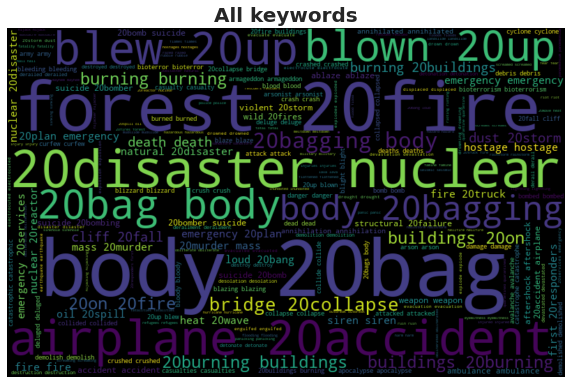

In [ ]:
# getting all the keywords from keyword column
all_keywords = " ".join([keyword for keyword in full_df["keyword"].dropna()])

# visualizing keywords
word_cloud= WordCloud(width=800,
                      height=500,
                      max_font_size=112,
                      random_state=24).generate(all_keywords)

# plotting 
plt.figure(figsize=(10, 8))
plt.title("All keywords", size=20, weight="bold")
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

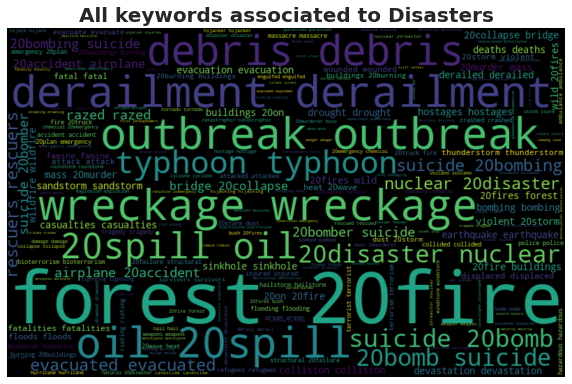

In [ ]:
# all keywords from tweets associated to a disaster 
all_disaster_keywords = " ".join([keyword for keyword in full_df[full_df["target"]==1]["keyword"].dropna()])

# visualizing keywords
word_cloud= WordCloud(width=800,
                      height=500,
                      max_font_size=112,
                      random_state=24).generate(all_disaster_keywords)

# plotting 
plt.figure(figsize=(10, 8))
plt.title("All keywords associated to Disasters", size=20, weight="bold")
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

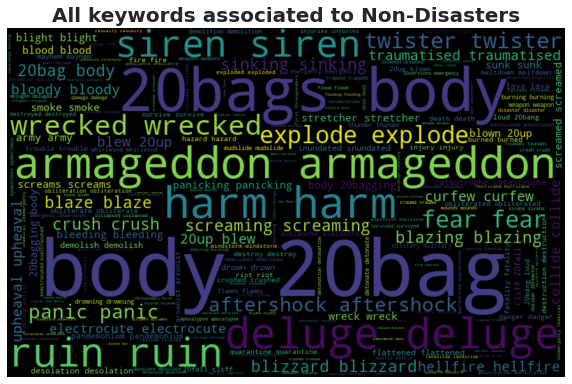

In [ ]:
# all keywords from tweets NOT associated to disaster
all_non_disaster_keywords = " ".join([keyword for keyword in full_df[full_df["target"]==0]["keyword"].dropna()])

# visualizing keywords
word_cloud= WordCloud(width=800,
                      height=500,
                      max_font_size=112,
                      random_state=24).generate(all_non_disaster_keywords)

# plotting 
plt.figure(figsize=(10, 8))
plt.title("All keywords associated to Non-Disasters", size=20, weight="bold")
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

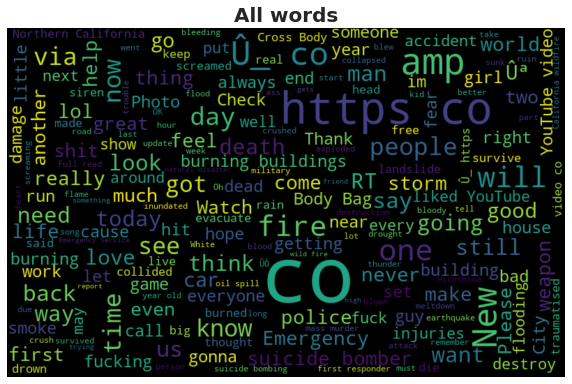

In [ ]:
# keywords from our tweets 
all_tweets = " ".join([word for word in full_df["text"]])

# visualizing tweets
word_cloud= WordCloud(width=800,
                      height=500,
                      max_font_size=112,
                      random_state=24).generate(all_tweets)

# plotting 
plt.figure(figsize=(10, 8))
plt.title("All words", size=20, weight="bold")
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

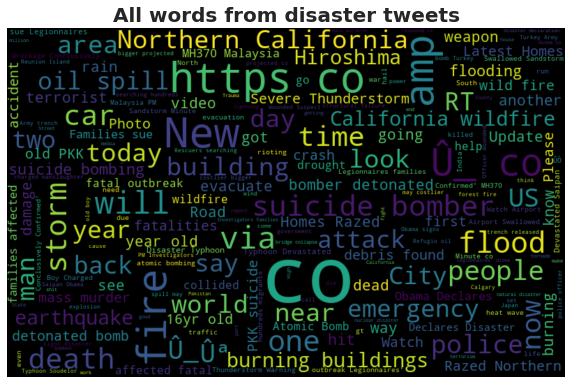

In [ ]:
# keywords from our tweets associated to disasters
all_disaster_tweets = " ".join([word for word in full_df[full_df["target"]==1]["text"]])

# visualizing tweets
word_cloud= WordCloud(width=800,
                      height=500,
                      max_font_size=112,
                      random_state=24).generate(all_disaster_tweets)

# plotting 
plt.figure(figsize=(10, 8))
plt.title("All words from disaster tweets", size=20, weight="bold")
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

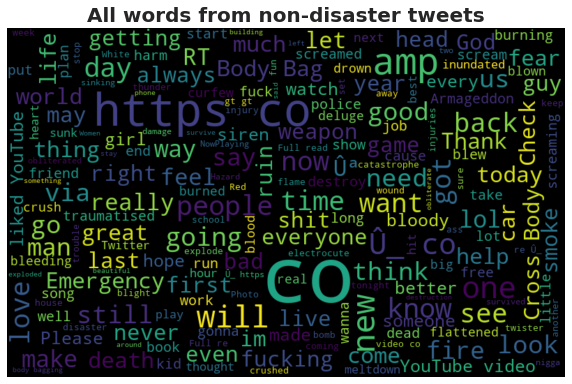

In [ ]:
# keywords from our tweets associated to non-disasters
all_non_disaster_tweets = " ".join([word for word in full_df[full_df["target"]==0]["text"]])

# visualizing tweets
word_cloud= WordCloud(width=800,
                      height=500,
                      max_font_size=112,
                      random_state=24).generate(all_non_disaster_tweets)

# plotting 
plt.figure(figsize=(10, 8))
plt.title("All words from non-disaster tweets", size=20, weight="bold")
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
# keyword to target counts
keyword_count_df = pd.DataFrame(full_df.groupby(["keyword", "target"])["text"].count()).rename(columns={"text":"count"})
keyword_count_df.head(50)

### Text Stats

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Code From https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert

STOPWORDS = set(stopwords.words("english"))

# word_count
train_df['word_count'] = train_df['text'].apply(lambda x: len(str(x).split()))
test_df['word_count'] = test_df['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
train_df['unique_word_count'] = train_df['text'].apply(lambda x: len(set(str(x).split())))
test_df['unique_word_count'] = test_df['text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
train_df['stop_word_count'] = train_df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
test_df['stop_word_count'] = test_df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# url_count
train_df['url_count'] = train_df['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
test_df['url_count'] = test_df['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
train_df['mean_word_length'] = train_df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df['mean_word_length'] = test_df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
train_df['char_count'] = train_df['text'].apply(lambda x: len(str(x)))
test_df['char_count'] = test_df['text'].apply(lambda x: len(str(x)))

# punctuation_count
train_df['punctuation_count'] = train_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
test_df['punctuation_count'] = test_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
train_df['hashtag_count'] = train_df['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
test_df['hashtag_count'] = test_df['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
train_df['mention_count'] = train_df['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
test_df['mention_count'] = test_df['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

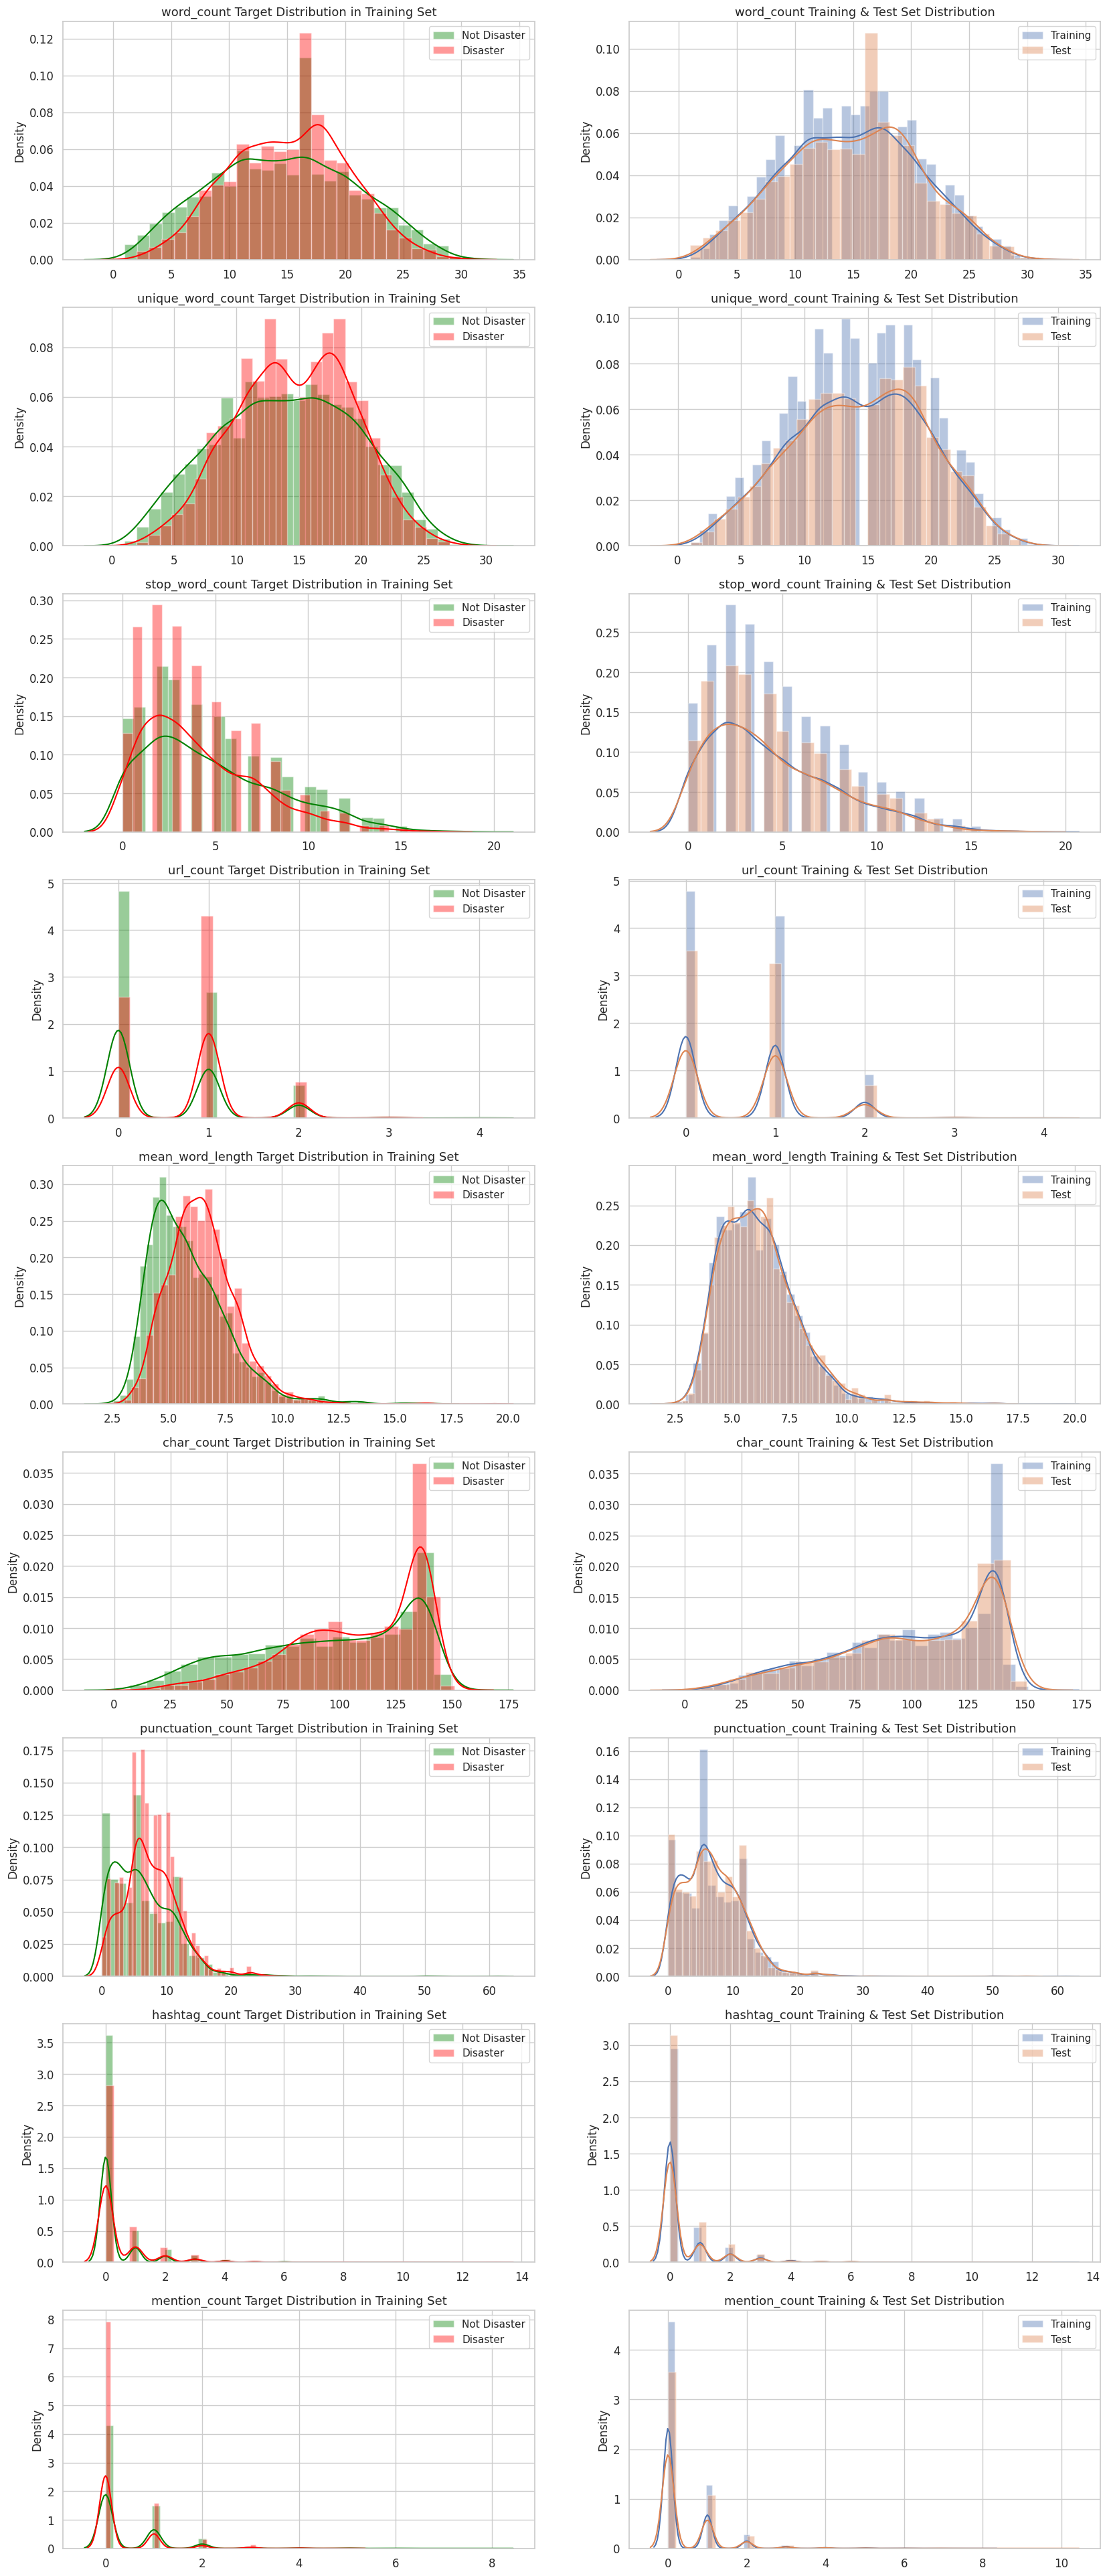

In [ ]:
# Code From https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert
METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
                'char_count', 'punctuation_count', 'hashtag_count', 'mention_count']

DISASTER_TWEETS = train_df['target'] == 1

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.distplot(train_df.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=axes[i][0], color='green')
    sns.distplot(train_df.loc[DISASTER_TWEETS][feature], label='Disaster', ax=axes[i][0], color='red')

    sns.distplot(train_df[feature], label='Training', ax=axes[i][1])
    sns.distplot(test_df[feature], label='Test', ax=axes[i][1])
    
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()
    
    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
    axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

plt.show()

# Preprocessing & Transformations

In [ ]:
# function to clean tweets
def clean_tweet(tweet:str) -> str:
    """
    Convert all text to lowercase, remove stock market tickers, RT symbol, hyperlinks and the hastag symbol
    :param tweet: tweet by a unique user
    :return: cleaned string without hashtags, emojis, and punctuation
    """
    # make text lower case
    tweet = tweet.lower()
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', str(tweet))
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', str(tweet))
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', str(tweet))
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', str(tweet))
    
    # remove punctuation
    punct = set(string.punctuation)
    tweet = "".join(ch for ch in tweet if ch not in punct)
    
    # remove stopwords
    stop_words = set(stopwords.words("english"))
    tweet = " ".join(word for word in tweet.split() if word not in stop_words)
    
    return tweet

def target_relabel(df:pd.DataFrame) -> pd.DataFrame:
    """
    Relabel duplicate tweets that are mislabelled in the training dataset
    :param df: A pandas dataframe with a "target" column
    :return: df
    """
    # manually relabel all mislabelled targets
    df.loc[df["text"]==
           "#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect",
           "target"]= 0
    df.loc[df["text"]==
          "#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption",
          "target"] = 0
    df.loc[df["text"]==
          ".POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4",
          "target"] = 0
    df.loc[df["text"]==
          "CLEARED:incident with injury:I-495  inner loop Exit 31 - MD 97/Georgia Ave Silver Spring",
          "target"] = 1
    df.loc[df["text"]==
          "He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam",
          "target"] = 0
    df.loc[df["text"]==
          "Hellfire is surrounded by desires so be careful and donÛªt let your desires control you! #Afterlife",
          "target"] = 0
    df.loc[df["text"]==
          "The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'",
          "target"] = 0
    df.loc[df["text"]=="To fight bioterrorism sir.", "target"] = 0
    df.loc[df["text"]==
          "that horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time",
          "target"] = 0
    return df

In [ ]:
# seperate off train and test
train = full_df.iloc[:len(train_df), :]
test = full_df.iloc[len(train_df):, :]

In [ ]:
# clean tweets
train["text_clean"] = train["text"].apply(clean_tweet)
test["text_clean"] = test["text"].apply(clean_tweet)
train.head()

,id,keyword,location,text,target,text_clean
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0,deeds reason earthquake may allah forgive us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1.0,residents asked shelter place notified officer...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1.0,13000 people receive wildfires evacuation orde...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1.0,got sent photo ruby alaska smoke wildfires pou...


In [ ]:
# relabel targets in train
train_df = target_relabel(train_df)

# checking if old different labels are now all the same
train_diff_label = train_duplicates.iloc[diff_label_idx].index
# will generate new example after each run
train_df.loc[train_df["text"] == train_diff_label[np.random.randint(0, len(train_diff_label))], ["text", "target"]]

,text,target
4284,The Prophet (peace be upon him) said 'Save you...,0
4286,The Prophet (peace be upon him) said 'Save you...,0
4292,The Prophet (peace be upon him) said 'Save you...,0
4304,The Prophet (peace be upon him) said 'Save you...,0
4309,The Prophet (peace be upon him) said 'Save you...,0
4318,The Prophet (peace be upon him) said 'Save you...,0


In [ ]:
# target variable 
y = train["target"].values

# initializing Kfold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=24)

# count vectorizer transformation
count_vect = CountVectorizer()
count_vect.fit(train["text_clean"].values.tolist() + test["text_clean"].values.tolist())
train_count_vect = count_vect.transform(train["text_clean"])

# tfidf vectorizer transformation 
tfidf_vect = TfidfVectorizer()
tfidf_vect.fit(train["text_clean"].values.tolist() + test["text_clean"].values.tolist())
train_tfidf_vect = tfidf_vect.transform(train["text_clean"])